In [ ]:
# Mount Drive - Used Google Colab for access to GPU
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
# Import Libraries

import keras
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import transform
from skimage.transform import rotate
from tqdm import tqdm_notebook
import PIL
from skimage import io


Using TensorFlow backend.


In [0]:
# Set some parameters
im_width = 128
im_height = 128
path_train_image = '/content/drive/My Drive/data/train/image/'
path_train_mask = '/content/drive/My Drive/data/train/label/'
path_train = '/content/drive/My Drive/data/train/'


### Take a Look at Images and Masks

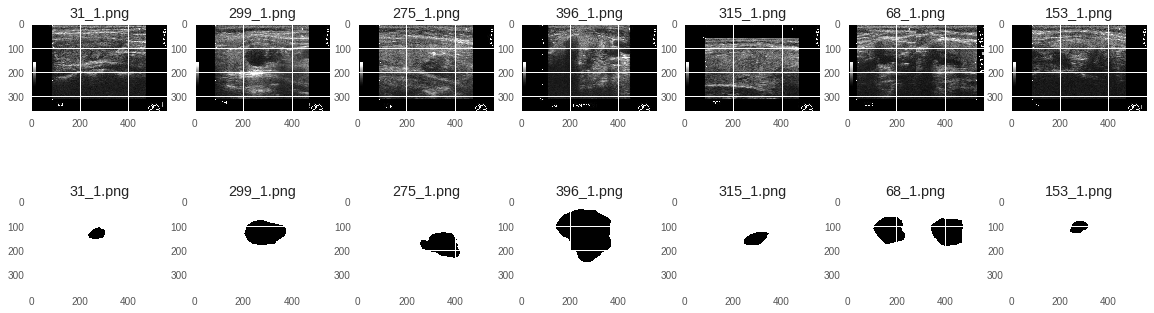

In [0]:
# Create a few sample plots

# Initialize array
image_array = []

# Append image names to array
for root, dirs, files in os.walk(path_train_image): 
    image_array = files

# Set number of rows and columns for plot output
col_size = 7
row_size = 2
 
# Randomize the images we are going to output
rand_id_array = random.sample(range(0, len(image_array)), col_size)

# Initialize Plot
fig, ax = plt.subplots(row_size, col_size, figsize=(20,6))  

# Plot images in first row and masks in second
for row in range(0,row_size): 
    image_index = 0
    if (row==0): 
        path= path_train_image
    else: 
        path = path_train_mask
    
    for col in range(0,col_size):
        img = load_img(path+image_array[rand_id_array[image_index]])
        ax[row][col].imshow(img)
        ax[row][col].set_title(image_array[rand_id_array[image_index]])
        image_index += 1
    
    plt.show()

### Data Processing

In [ ]:
# Get and resize train images and masks
def get_data(path):
    
    # Create generator of image paths
    ids = next(os.walk(path_train+'/image/'))[2]
  
    # Initialize empty arrays for Images and Masks
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

    # Load, resize and save images and masks in their respective array
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        
        # Load Image
        img = load_img(path + '/image/' + id_, color_mode = "grayscale")

        # Convert image to Array
        x_img = img_to_array(img)

        # Resize Image
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        mask = load_img(path + '/label/' + id_, color_mode = "grayscale")

        # Convert Mask to array
        mask = img_to_array(mask)

        # Resize Array
        mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        y[n] = mask / 255

    return X, y

X, y = get_data(path_train)

In [0]:
# Create Train, Test, Validation split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=256)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.11, random_state=256)

In [0]:
# Print Array Shapes

print ("Train Shape: "+ str(X_train.shape))
print ("Valid Shape: "+ str(X_valid.shape))
print ("Test Shape:  "+ str(X_test.shape))

Train Shape: (374, 128, 128, 1)
Valid Shape: (47, 128, 128, 1)
Test Shape:  (47, 128, 128, 1)


### Data Augmentation

In [0]:
# Data Augmentation


# Flip Images
flip_x = [np.fliplr(i) for i in X_train]
flip_y = [np.fliplr(i) for i in Y_train]

# Rotate images at random between [0,20]

# Set Seed
np.random.seed(1)

# Rotate X
rotate_x_1 = [rotate(i, np.random.uniform(0,20)) for i in X_train]

# Reset Seed
np.random.seed(1)

# Rotate Y
rotate_y_1 = [rotate(i, np.random.uniform(0,20)) for i in Y_train]


# Rotate images at random between [-20,0]

# Set Seed
np.random.seed(0)

# Rotate X
rotate_x_2 = [rotate(i, np.random.uniform(-20,0)) for i in X_train]

# Reset Seed
np.random.seed(0)

# Rotate Y
rotate_y_2 = [rotate(i, np.random.uniform(-20,0)) for i in Y_train]

# Append Flip
X_train = np.append(X_train, flip_x, axis=0)
Y_train = np.append(Y_train, flip_y, axis=0)

# Append rotate_1
X_train = np.append(X_train, rotate_x_1, axis=0)
Y_train = np.append(Y_train, rotate_y_1, axis=0)

# Append rotate_2
X_train = np.append(X_train, rotate_x_2, axis=0)
Y_train = np.append(Y_train, rotate_y_2, axis=0)



In [0]:
# Take a look at Train Shape after Augmentation

print ("Train Shape After Validation: "+ str(X_train.shape))


Train Shape After Validation: (1496, 128, 128, 1)


### Create and Run Model

In [0]:
# Define Model with Dropout

def getUnetOutput(input_layer, features):
    #downsampling 1
    conv1 = Conv2D(features, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(features, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1) 
 
    #downsampling 2
    conv2 = Conv2D(features * 2, (3, 3), activation='relu', padding='same') (pool1)
    conv2 = Conv2D(features * 2, (3, 3), activation='relu', padding='same') (conv2)
    pool2 = MaxPooling2D((2, 2)) (conv2)
    pool2 = Dropout(0.3)(pool2)
 
    #downsampling 3
    conv3 = Conv2D(features * 2**2, (3, 3), activation='relu', padding='same') (pool2)
    conv3 = Conv2D(features * 2**2, (3, 3), activation='relu', padding='same') (conv3)
    pool3 = MaxPooling2D((2, 2)) (conv3)   
    pool3 = Dropout(0.4)(pool3)
 
    #downsampling 4
    conv4 = Conv2D(features * 2**3, (3, 3), activation='relu', padding='same') (pool3)
    conv4 = Conv2D(features * 2**3, (3, 3), activation='relu', padding='same') (conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (conv4)
    pool4 = Dropout(0.5)(pool4)
 
    #middle bridge 5
    conv5 = Conv2D(features * 2**4, (3, 3), activation='relu', padding='same') (pool4)
    conv5 = Conv2D(features * 2**4, (3, 3), activation='relu', padding='same') (conv5)
 
    #upsampling 6
    tran6 = Conv2DTranspose(features * 2**3, (2, 2), strides=(2, 2), padding='same') (conv5)
    tran6 = concatenate([tran6, conv4])  
    tran6 = Dropout(0.5)(tran6)
    conv6 = Conv2D(features * 2**3, (3, 3), activation='relu', padding='same') (tran6)
    conv6 = Conv2D(features * 2**3, (3, 3), activation='relu', padding='same') (conv6)
 
    #upsampling 7
    tran7 = Conv2DTranspose(features * 2**2, (2, 2), strides=(2, 2), padding='same') (conv6)
    tran7 = concatenate([tran7, conv3])   #merge 2 layers into 1 
    tran7 = Dropout(0.4)(tran7)
    conv7 = Conv2D(features * 2**2, (3, 3), activation='relu', padding='same') (tran7)
    conv7 = Conv2D(features * 2**2, (3, 3), activation='relu', padding='same') (conv7)
 
    #upsampling 8
    tran8 = Conv2DTranspose(features * 2, (2, 2), strides=(2, 2), padding='same') (conv7)
    tran8 = concatenate([tran8, conv2])   #merge 2 layers into 1 
    tran8 = Dropout(0.3)(tran8)
    conv8 = Conv2D(features * 2, (3, 3), activation='relu', padding='same') (tran8)
    conv8 = Conv2D(features * 2, (3, 3), activation='relu', padding='same') (conv8)
 
    #upsampling 9
    tran9 = Conv2DTranspose(features, (2, 2), strides=(2, 2), padding='same') (conv8)
    tran9 = concatenate([tran9, conv1])   #merge 2 layers into 1 
    tran9 = Dropout(0.25)(tran9)
    conv9 = Conv2D(features, (3, 3), activation='relu', padding='same') (tran9)
    conv9 = Conv2D(features, (3, 3), activation='relu', padding='same') (conv9)
 
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(conv9)
 
    return output_layer

In [0]:
input_layer = Input((im_width, im_height, 1))
output_layer = getUnetOutput(input_layer, 8)
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy",IoU])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [ ]:
earlystopper = EarlyStopping(patience=11, verbose=1)
checkpointer = ModelCheckpoint('/content/drive/My Drive/model-segment-4_0.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
epochs = 50
batch_size = 8
results = model.fit(X_train, Y_train,
                    validation_data=[X_valid, Y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[earlystopper, checkpointer, reduce_lr])

### Evaluate Model - Validation

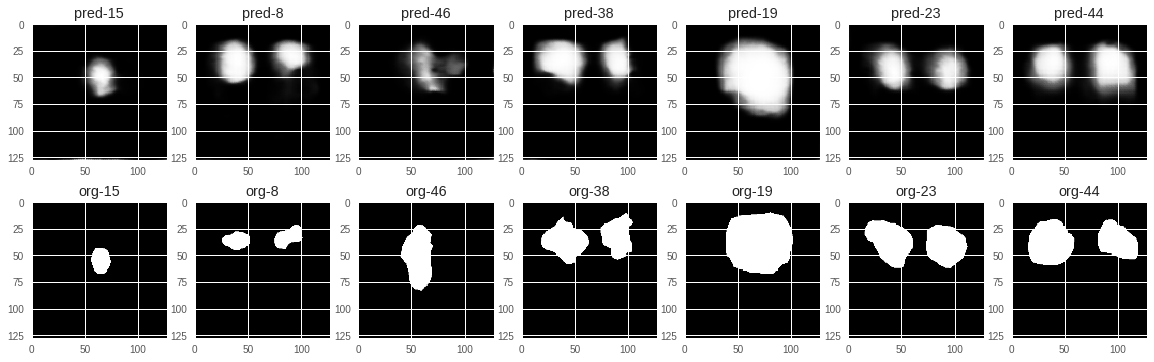

In [0]:
preds_valid = model.predict(X_valid).reshape(-1, 128, 128)
org_valid = np.array([x for x in Y_valid.reshape(-1, 128, 128)])


col_size = 7
row_size = 2
 
rand_id_array = random.sample(range(0, len(org_valid)), col_size)
 
fig, ax = plt.subplots(row_size, col_size, figsize=(20,6))  
 
for row in range(0,row_size): 
    image_index = 0 
    if (row==0): 
        valid_array = preds_valid
        title_prefix = "pred"
    else: 
        valid_array = org_valid  
        title_prefix = "org"
    
    for col in range(0,col_size):
        ax[row][col].imshow(valid_array[rand_id_array[image_index]], cmap="Greys")
        ax[row][col].set_title("{}-{}".format(title_prefix, rand_id_array[image_index]))
        image_index += 1
    
plt.show()

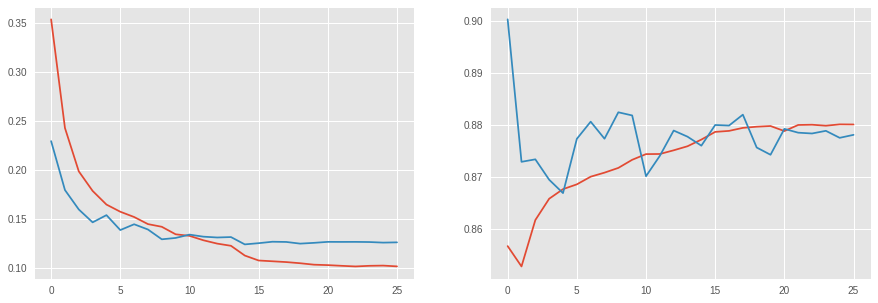

In [0]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(results.epoch, results.history["loss"], label="Train loss")
ax_loss.plot(results.epoch, results.history["val_loss"], label="Validation loss")
ax_acc.plot(results.epoch, results.history["acc"], label="Train accuracy")
ax_acc.plot(results.epoch, results.history["val_acc"], label="Validation accuracy")

In [0]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(org_valid, np.int32(preds_valid > threshold)) for threshold in thresholds])

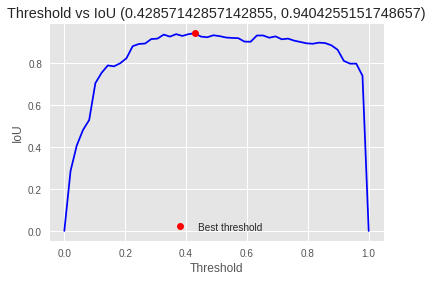

In [0]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
 
plt.plot(thresholds, ious,"b")
plt.plot(threshold_best, iou_best, "ro", label="Best threshold",)
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

### Evaluate Model - Test

In [0]:
# Test Data
predict_test = (model.predict(X_test)).reshape(-1, 128, 128)

In [0]:
thresholds = np.linspace(0, 1, 50)
org_test = np.array([x for x in Y_test.reshape(-1, 128, 128)])
ious = np.array([iou_metric_batch(org_test, np.int32(predict_test > threshold)) for threshold in thresholds])


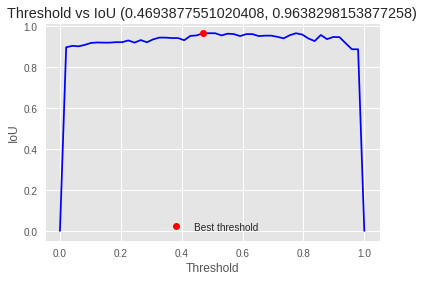

In [0]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
 
plt.plot(thresholds, ious,"b")
plt.plot(threshold_best, iou_best, "ro", label="Best threshold",)
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

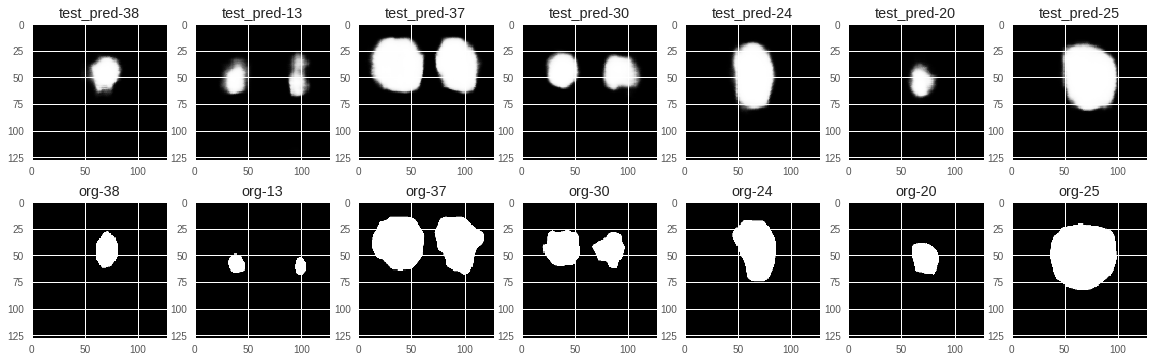

In [0]:
col_size = 7
row_size = 2
 
rand_id_array = random.sample(range(0, len(org_test)), col_size)
 
fig, ax = plt.subplots(row_size, col_size, figsize=(20,6))  
 
for row in range(0,row_size): 
    image_index = 0 
    if (row==0): 
        test_array = predict_test
        title_prefix = "test_pred"
    else: 
        test_array = org_test  
        title_prefix = "org"
    for col in range(0,col_size):
        ax[row][col].imshow(test_array[rand_id_array[image_index]], cmap="Greys")
        ax[row][col].set_title("{}-{}".format(title_prefix, rand_id_array[image_index]))
        image_index += 1
    
plt.show()

### Save and Load Model

In [0]:
# Save Model 
model.save('my_model_best_1.h5')

### Metric Functions

In [0]:
def raw_iou(y_true, y_pred):
    results = []
    y_pred = y_pred > 0.3
    for i in range(0,y_true.shape[0]):
        intersect = np.sum( y_true[i,:,:] * y_pred[i,:,:] )
        union = np.sum( y_true[i,:,:] ) + np.sum( y_pred[i,:,:] ) - intersect + 1e-7
        iou = np.mean((intersect/union)).astype(np.float32)
        results.append( iou )
    return np.mean( results )

def IoU(y_true, y_pred):
    iou = tf.py_func(raw_iou, [y_true, y_pred], tf.float32)
    return iou


In [0]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

### Load Model

In [ ]:
new_model = keras.models.load_model('/content/drive/My Drive/model-segment-8.h5')

In [0]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, 128, 128, 8)  80          input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 128, 128, 8)  584         conv2d_119[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_26 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_120[0][0]                 
__________________________________________________________________________________________________
dropout_51